In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer
from qiskit import Aer
from qiskit import execute
import numpy as np
%matplotlib inline
my_style = {'cregbundle': True, 'reversebits': True, 'plotbarriers' : True}

In this notebook, we will develop a circuit modelling the quantum teleportation process. The first step of the teleportation procedure is to prepare a Bell state shared by Alice and Bob. So let us first understand how a circuit can be used to set up a Bell state. A Bell state is given by applying the unitary operator
$$
C_{NOT} (H \otimes I)
$$
to the states of the computational basis, where the qubit on which H acts is the control qubit of the CNOT gate. So as a circuit, this looks as follows (using the Qiskit tensor product order, i.e. the leftmost qubit in the tensor product is the most significant qubit).

In [2]:
#######################################################
# Transform the computational basis into the Bell     #
# basis.                                              #
# Input: the quantum register on which we operate     #
#######################################################
def computationalBasisToBellBasis(q,*c):
    circuit = QuantumCircuit(q,*c)
    circuit.h(q[1])
    circuit.cx(q[1], q[0])
    return circuit

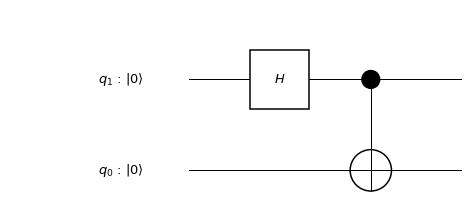

In [3]:
q = QuantumRegister(2, "q")
circuit = computationalBasisToBellBasis(q)
drawer(circuit, scale=1.4,style=my_style)

Let us first test this in isolation and see whether it works. To to so, we use the state vector simulator.

In [4]:
def stateVectorToString(vector, places = 3):
    s = ""
    count = 0
    for i in range(len(vector)):
        #
        # First format the coefficient
        #
        x = round(vector[i], places)
        if x.imag != 0:
            coeff = "(" + format(x.real,'+') +  format(x.imag,'+') + "i)"
        else:
            coeff = format(x.real,'+') 
        if (x != 0):
            s = s + coeff + "|" + format(i, '02b') + ">"
            count = count + 1
    return s


def testBellBasis():
    backend = Aer.get_backend('statevector_simulator') 
    for x in range(4):
        q = QuantumRegister(2, "q")
        transform_circuit = computationalBasisToBellBasis(q)
        init_circuit = QuantumCircuit(q)
        initial_state = np.zeros(4, dtype=complex)
        initial_state[x] = 1.0
        init_circuit.initialize(initial_state, q)
        circuit = init_circuit + transform_circuit
        job = execute(circuit, backend)
        out = job.result().get_statevector()
        #
        # print the results
        #
        print("|" + format(x, '02b') + ">" + " ----> " + stateVectorToString(out))

In [5]:
testBellBasis()

|00> ----> +0.707|00>+0.707|11>
|01> ----> +0.707|01>+0.707|10>
|10> ----> +0.707|00>-0.707|11>
|11> ----> +0.707|01>-0.707|10>


Now let us use this in the teleportation circuit. Recall that the protocol involves three qubits that we call A,B and C. For our tests, we initialize these qubits using Qiskits initialize function. We use the mapping

q1 = A

q0 = B

q2 = C

In [6]:
q = QuantumRegister(3, "q")
c0 = ClassicalRegister(1, "c0")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")
init_circuit = QuantumCircuit(q, c0, c1, c2)
initial_state = np.zeros(2**3, dtype=complex)
initial_state[0] = 1.0
init_circuit.initialize(initial_state, [q[0], q[1], q[2]])


We now build the actual teleportation circuit. We first create an entangled Bell state shared between Alice and Bob. 

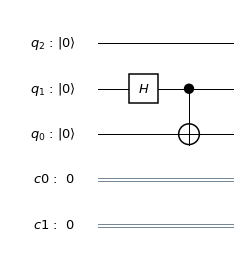

In [7]:
teleportation_circuit = computationalBasisToBellBasis(q, c0, c1)
drawer(teleportation_circuit, style=my_style)

Next Alice will measure qubits A and C, i.e. qubits q1 and q2, in the Bell basis (in that order, i.e. A is the most significant qubit). To do this, we first apply a circuit that maps the Bell basis to the standard basis and then measure in the standard basis. This transformation is easy - just apply the circuit above that we have used to transform the computational basis into the Bell basis in reverse order.

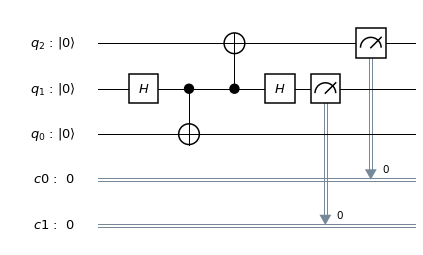

In [8]:
teleportation_circuit.barrier()
teleportation_circuit.cx(q[1], q[2])
teleportation_circuit.h(q[1])
teleportation_circuit.barrier()
teleportation_circuit.measure(q[2], c0[0])
teleportation_circuit.measure(q[1], c1[0])
teleportation_circuit.barrier()
drawer(teleportation_circuit, style=my_style)

We know apply conditional operations. If the measurement of C was one, then Bob needs to apply a bit-flip operator. If the measurement of A was 1, he needs to a apply a Z operator. 

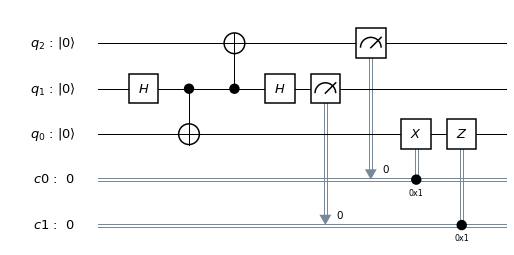

In [9]:
teleportation_circuit.x(q[0]).c_if(c0, 1)
teleportation_circuit.z(q[0]).c_if(c1, 1)
teleportation_circuit.barrier(q)
drawer(teleportation_circuit, style=my_style)

And finally, we measure qubit B into bit two of the classical register.

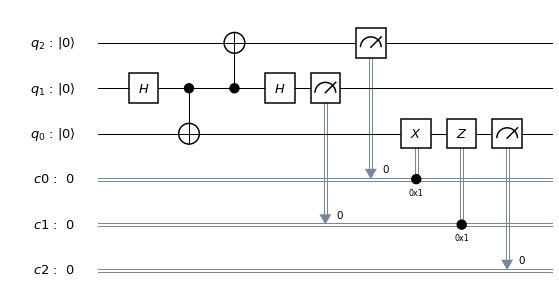

In [10]:
measurement_circuit = QuantumCircuit(q,c2)
measurement_circuit.measure(q[0], c2[0])
circuit = teleportation_circuit + measurement_circuit
drawer(circuit, style=my_style)

Now let us test this. As our input for the qubit C is zero in this case, we expect the measurement of bit B, i.e. c2, to be zero in all cases.

In [11]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend)
counts = job.result().get_counts()
counts

{'0 0 0': 247, '0 0 1': 261, '0 1 0': 269, '0 1 1': 247}

Next let us test with the state 1. We add a preparational step which simply uses a Pauli X to set qubit C (q[2]) to one. As a result, the measurement of c2 should now give us one in all cases, i.e. the leftmost bit of all outcomes should be one.

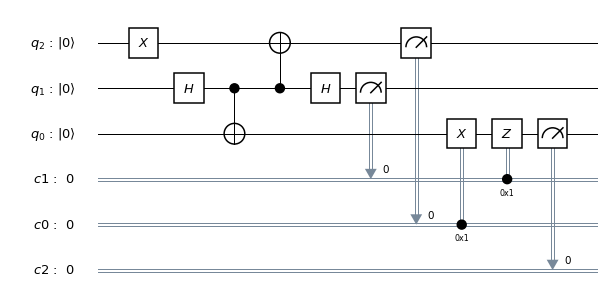

In [12]:
prep = QuantumCircuit(q)
prep.x(q[2])
prep.barrier()
test_circuit = prep + teleportation_circuit + measurement_circuit
drawer(test_circuit, style=my_style)

In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(test_circuit, backend)
counts = job.result().get_counts()
counts

{'1 0 0': 257, '1 0 1': 256, '1 1 0': 267, '1 1 1': 244}

Finally, we can do a more advanced test. Given any sequence of gates that we apply to qubit C (q[2]), we should be able to apply the inverse sequence to qubit B (q[0]) after doing the teleportation and should always get the initial state $|0\rangle$ back. Let us try this with the Hadamard gate.

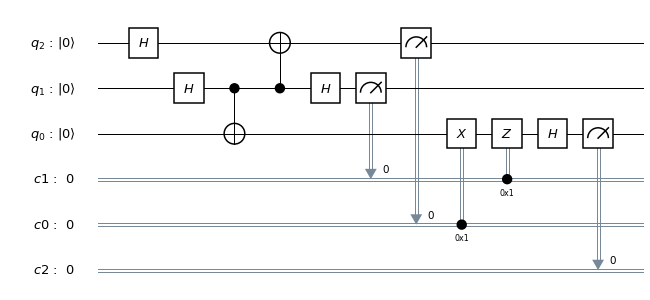

In [14]:
prep = QuantumCircuit(q)
prep.h(q[2])
#prep.u1(0.6, q[2])
prep.barrier()
post = QuantumCircuit(q)
#post.u1(-0.6, q[0])
post.h(q[0])
test_circuit = prep + teleportation_circuit + post + measurement_circuit
drawer(test_circuit, style=my_style)

In [15]:
backend = Aer.get_backend('qasm_simulator')
job = execute(test_circuit, backend)
counts = job.result().get_counts()
counts

{'0 0 0': 258, '0 0 1': 276, '0 1 0': 236, '0 1 1': 254}

In [16]:
print(test_circuit.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c1[1];
creg c0[1];
creg c2[1];
h q[2];
barrier q[0],q[1],q[2];
h q[1];
cx q[1],q[0];
barrier q[0],q[1],q[2];
cx q[1],q[2];
h q[1];
barrier q[0],q[1],q[2];
measure q[2] -> c0[0];
measure q[1] -> c1[0];
barrier q[0],q[1],q[2];
if(c0==1) x q[0];
if(c1==1) z q[0];
barrier q[0],q[1],q[2];
h q[0];
measure q[0] -> c2[0];

